  ##                      Emotion classification using Deep Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/My Drive/Colab Notebooks/vg/NLP/

/content/drive/My Drive/Colab Notebooks/vg/NLP


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/vg/NLP


In [ ]:
import pandas as pd
import numpy as np
 
import nltk
from nltk.corpus import stopwords

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from gensim.models import FastText


from contractions import contraction_map
import string,re

from nltk.stem import WordNetLemmatizer


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [ ]:
from keras.layers import Dense, Embedding, Bidirectional, SpatialDropout1D,Input, TimeDistributed,Flatten, LSTM,GRU,Dropout
from keras.models import Sequential,save_model,Model
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf

### Data cleaning

In [ ]:
data = pd.read_csv('datasets/crowdflower-sentiment-analysis-in-text/text_emotion.csv')

In [ ]:
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [ ]:
data.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [ ]:
df_temp = data.copy()

In [ ]:
df_temp.dtypes

tweet_id      int64
sentiment    object
author       object
content      object
dtype: object

In [ ]:
# Dropping rows with other emotion labels
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'boredom'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'enthusiasm'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'empty'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'fun'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'relief'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'surprise'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'love'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'hate'].index)

In [ ]:
df_temp.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [ ]:
df_temp

,tweet_id,sentiment,author,content
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
...,...,...,...,...
39992,1753918881,neutral,_Alectrona_,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,bushidosan,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,happiness,courtside101,Succesfully following Tayla!!
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor


In [ ]:
df_temp = df_temp.drop('author',axis=1)
df_temp

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...,...
39992,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,happiness,Succesfully following Tayla!!
39995,1753918954,neutral,@JohnLloydTaylor


In [ ]:
df_temp.reset_index(drop=True,inplace=True)

In [ ]:
df_temp

,tweet_id,sentiment,content
0,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
1,1956967696,sadness,Funeral ceremony...gloomy friday...
2,1956968416,neutral,@dannycastillo We want to trade with someone w...
3,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
4,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...,...
27576,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
27577,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
27578,1753918900,happiness,Succesfully following Tayla!!
27579,1753918954,neutral,@JohnLloydTaylor


In [ ]:
df_temp.shape

(27581, 3)

In [ ]:
df_temp.drop('tweet_id',axis=1,inplace=True)

In [ ]:
df_temp.columns = ['sentiment','text']

In [ ]:
df_temp.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [ ]:
## Handling Class imbalance (Synthetic Oversampling)

In [ ]:
class_count_0 , class_count_1, class_count_2, class_count_3, class_count_4 = df_temp.sentiment.value_counts()

In [ ]:
class_count_anger_updated = df_temp[df_temp['sentiment'] == 'anger'].sample(class_count_3,replace=True)

In [ ]:
class_count_anger_updated.reset_index(drop=True,inplace=True)

In [ ]:
class_count_neutral = df_temp[df_temp['sentiment'] == 'neutral']
class_count_worry = df_temp[df_temp['sentiment'] == 'worry']
class_count_happiness = df_temp[df_temp['sentiment'] == 'happiness']
class_count_sadness= df_temp[df_temp['sentiment'] == 'sadness']

In [ ]:
df = pd.concat([class_count_neutral,class_count_worry,class_count_happiness,class_count_sadness,class_count_anger_updated],axis=0) 

In [ ]:
df.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
anger        5165
sadness      5165
Name: sentiment, dtype: int64

In [ ]:
df

,sentiment,text
2,neutral,@dannycastillo We want to trade with someone w...
8,neutral,cant fall asleep
17,neutral,No Topic Maps talks at the Balisage Markup Con...
25,neutral,@cynthia_123 i cant sleep
26,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
5160,anger,&quot;locked up abroad&quot; makes bein half b...
5161,anger,Shout out to my moms for wakin me up so premat...
5162,anger,Did a historical Jesus ever exist? Im finding ...
5163,anger,@msaysrawr *points at the gear question I just...


In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
df

,sentiment,text
0,neutral,@dannycastillo We want to trade with someone w...
1,neutral,cant fall asleep
2,neutral,No Topic Maps talks at the Balisage Markup Con...
3,neutral,@cynthia_123 i cant sleep
4,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
32631,anger,&quot;locked up abroad&quot; makes bein half b...
32632,anger,Shout out to my moms for wakin me up so premat...
32633,anger,Did a historical Jesus ever exist? Im finding ...
32634,anger,@msaysrawr *points at the gear question I just...


### Data pre-processing

##### Stopword Exclusion

In [ ]:
#Using Sentiment lexicons to be excluded from stopwords

In [ ]:
df_pos = pd.read_csv('./lexicons/positive.csv')
df_neg = pd.read_csv('./lexicons/negative.csv')

### Helper functions 

In [ ]:
def expand_text(text):
    text = text.lower()
    text = text.replace("`","'")
    
    #Expand Contractions
    contraction_dict = contraction_map
    contraction_keys = list(contraction_dict.keys())
    
    for word in text.split():
        if word in contraction_keys:
            text = text.replace(word, contraction_dict[word])
        else:
            continue
    
    return text    

In [ ]:
def clean_text(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    
    df_pos_words = list(df_pos.words)
    df_neg_words = list(df_neg.words)
    
    positive = []
    for i in range(0,len(df_pos_words)):
        positive.append(df_pos_words[i].lower().replace(" ",""))
        
    negative = []
    for i in range(0,len(df_neg_words)):
        negative.append(df_neg_words[i].lower().replace(" ",""))
        
    pos_set = set(positive)
    neg_set = set(negative)
    
    keywords = set(["above","and","below","not"])
    
    keywords.update(pos_set)
    keywords.update(neg_set)
    
    stopwords_set = set(stopwords.words('english'))
    stops = stopwords_set - keywords
    
    
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    text = re.sub(r"[^A-Za-z0-9^,!./\'+-=]"," ",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"\'s"," ",text)
    text = re.sub(r"\'ve"," have ",text)
    text = re.sub(r"n't"," not ",text)
    text = re.sub(r"i'm"," i am ",text)
    text = re.sub(r"\'re"," are ",text)
    text = re.sub(r"\'d", " would ",text)
    text = re.sub(r"\'ll", " will ",text)
    text = re.sub(r","," ",text)
    text = re.sub(r"\."," ",text)
    text = re.sub(r"!"," ! ",text)
    text = re.sub(r"\/"," ",text)
    text = re.sub(r"\^"," ^ ",text)
    text = re.sub(r"\+"," + ",text)
    text = re.sub(r"\-"," - ",text)
    text = re.sub(r"\="," = ",text)
    text = re.sub(r"'"," ",text)
    text = re.sub(r"(\d+)(k)",r"\g<1>000",text)
    text = re.sub(r":", " : ",text)
    text = re.sub(r" e g "," eg ",text)
    text = re.sub(r"b g "," bg ",text)
    text = re.sub(r" u s "," american ",text)
    text = re.sub(r"\0s","0",text)
    text = re.sub(r"e - mail","email",text)
    text = re.sub(r"\s{2,}"," ",text)
    
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    
    return text

In [ ]:
df

,sentiment,text
0,neutral,@dannycastillo We want to trade with someone w...
1,neutral,cant fall asleep
2,neutral,No Topic Maps talks at the Balisage Markup Con...
3,neutral,@cynthia_123 i cant sleep
4,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
32631,anger,&quot;locked up abroad&quot; makes bein half b...
32632,anger,Shout out to my moms for wakin me up so premat...
32633,anger,Did a historical Jesus ever exist? Im finding ...
32634,anger,@msaysrawr *points at the gear question I just...


In [ ]:
df['text'] = df['text'].progress_apply(lambda x : expand_text(x))

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df['text'] = df['text'].progress_apply(lambda x: clean_text(x))

In [ ]:
df

,sentiment,text
0,neutral,dannycastillo want trade someone houston ticke...
1,neutral,cant fall asleep
2,neutral,topic map talk balisage markup conference 2009...
3,neutral,cynthia 123 cant sleep
4,neutral,missed bl y bus ! ! ! ! ! ! ! !
...,...,...
32631,anger,quot;locked abroad quot; make bein half brown ...
32632,anger,shout mom wakin prematurely ! preciate
32633,anger,historical jesus ever exist im finding hard pr...
32634,anger,msaysrawr point gear question posted cant get ...


In [ ]:
df = df.sample(frac=1)

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
df

,sentiment,text
0,happiness,vitriol : quot; lordmitchnz good evening kind ...
1,sadness,phyllis hyman unsung story sad
2,neutral,pierrino yes not forget koala pic pubquizzing ...
3,neutral,jeangrae whyd u feel awful last night
4,happiness,donnyosmond excited booked ticket vega we live...
...,...,...
32631,worry,well friday and usually start something awsome...
32632,happiness,teamwinnipeg gerry thank following me ! help s...
32633,happiness,good morning everyone nice day iloveitwhen sun...
32634,sadness,kalediscope girl cry allergic seafood


### create Tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

34512


In [ ]:
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences,maxlen=50)

## Use word embeddings (Fasttext)

In [ ]:
embeddings_index = {}
f = open('./embeddings/wiki-news-300d-1M-subword.vec',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype="float32")
    embeddings_index[word] = coefs
f.close()

## Create a weight matrix 

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word,index in tokenizer.word_index.items():
    if index > vocab_size -1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector 

## Model building 

In [ ]:
max_len = 50

In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10)
mc = ModelCheckpoint('./saved_models/best_model.h5',save_best_only=True,verbose=1)

In [ ]:
df['sentiment'].value_counts()

neutral      8638
worry        8459
happiness    5209
anger        5165
sadness      5165
Name: sentiment, dtype: int64

Test layers

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=max_len,trainable=False))
model_lstm.add(LSTM(128,dropout=0.5))
model_lstm.add(Dense(100,activation='relu'))
model_lstm.add(Dense(100,activation='relu'))
model_lstm.add(Dense(5,activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 300)           10353600  
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_20 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 505       
Total params: 10,596,753
Trainable params: 243,153
Non-trainable params: 10,353,600
_________________________________________________________________


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(df['sentiment'])
labels = to_categorical(labels)

In [ ]:
model_lstm.fit(data,labels,validation_split=0.1,epochs=10)

Train on 29372 samples, validate on 3264 samples
Epoch 1/10
29372/29372 [==============================] - 114s 4ms/step - loss: 1.4525 - accuracy: 0.3669 - val_loss: 1.2528 - val_accuracy: 0.4660
Epoch 2/10
29372/29372 [==============================] - 117s 4ms/step - loss: 1.2695 - accuracy: 0.4540 - val_loss: 1.1089 - val_accuracy: 0.5153
Epoch 3/10
29372/29372 [==============================] - 112s 4ms/step - loss: 1.1680 - accuracy: 0.4927 - val_loss: 1.0362 - val_accuracy: 0.5312
Epoch 4/10
29372/29372 [==============================] - 112s 4ms/step - loss: 1.1098 - accuracy: 0.5114 - val_loss: 1.0266 - val_accuracy: 0.5257
Epoch 5/10
29372/29372 [==============================] - 116s 4ms/step - loss: 1.0760 - accuracy: 0.5261 - val_loss: 1.0102 - val_accuracy: 0.5407
Epoch 6/10
29372/29372 [==============================] - 111s 4ms/step - loss: 1.0542 - accuracy: 0.5342 - val_loss: 0.9994 - val_accuracy: 0.5349
Epoch 7/10
29372/29372 [==============================] - 111s 

In [ ]:
txt = ["India Overtakes Russia As Third Worst-Hit Nation In COVID-19 Tally "]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model_lstm.predict(padded)
labels = ['anger',' happiness','neutral',' sadness','worry']
print(pred, labels[np.argmax(pred)])

[[2.2956649e-05 6.2824912e-02 2.4717882e-01 2.9051265e-01 3.9946073e-01]] worry


In [ ]:
txt = ["Won the lottery! yay!"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model_lstm.predict(padded)
labels = ['anger',' happiness','neutral',' sadness','worry']
print(pred, labels[np.argmax(pred)])

[[8.4052095e-05 3.9718437e-01 2.3107035e-01 1.4329648e-01 2.2836472e-01]]  happiness


In [ ]:
fp = './saved_models/best_model.h5'
save_model(model_lstm,fp,include_optimizer=True)

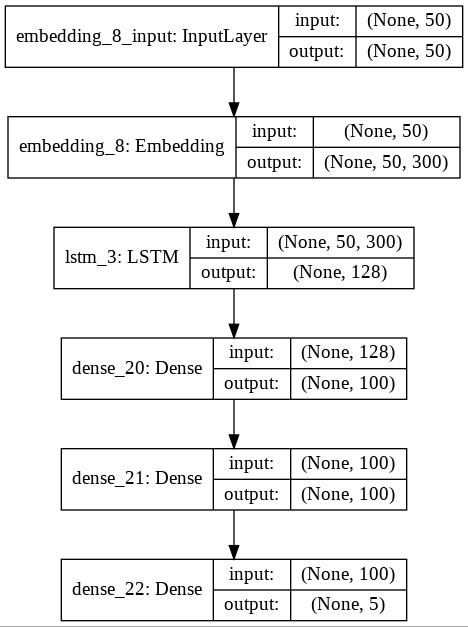

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='model_plot.jpeg', show_shapes=True, show_layer_names=True)

In [ ]:
def create_nn():
  model = Sequential()
  model.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=max_len,trainable=False))
  model.add(LSTM(128,dropout=0.5))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(5,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

  return model

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(df['sentiment'])
labels = to_categorical(labels)

In [ ]:
# Evaluate neural network using three-fold cross-validation
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

#Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_nn, 
                                 epochs=10,  
                                 verbose=0)

cross_val_score(neural_network,data, labels, cv=3)

array([0.54894751, 0.556485  , 0.55249125])